In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from math import floor
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [3]:
train_data_set = pd.read_csv('/content/drive/MyDrive/AI-Cyber-Detector/data/raw/UNSW_NB15_training-set.csv')
test_data_set = pd.read_csv('/content/drive/MyDrive/AI-Cyber-Detector/data/raw/UNSW_NB15_testing-set.csv')

In [4]:
train_data_set.shape

(82332, 45)

In [5]:
test_data_set.shape

(175341, 45)

In [6]:
train_data_set.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [7]:
train_data_set.drop(columns=["label"],inplace=True)
test_data_set.drop(columns=["label"],inplace=True)

In [8]:
train_data_set.attack_cat.value_counts()

,count
attack_cat,
Normal,37000
Generic,18871
Exploits,11132
Fuzzers,6062
DoS,4089
Reconnaissance,3496
Analysis,677
Backdoor,583
Shellcode,378


In [9]:
rare_attacks = ['Analysis', 'Backdoor', 'Shellcode', 'Worms']
train_data_set['attack_cat'] = train_data_set['attack_cat'].replace(rare_attacks, 'Other')
test_data_set['attack_cat'] = test_data_set['attack_cat'].replace(rare_attacks, 'Other')

In [10]:
train_data_set.attack_cat.value_counts()

,count
attack_cat,
Normal,37000
Generic,18871
Exploits,11132
Fuzzers,6062
DoS,4089
Reconnaissance,3496
Other,1682


In [11]:
attacks=train_data_set.attack_cat.unique()
attacks

array(['Normal', 'Reconnaissance', 'Other', 'DoS', 'Exploits', 'Fuzzers',
       'Generic'], dtype=object)

In [12]:
grouped = train_data_set.groupby(train_data_set.attack_cat)
dfs=[grouped.get_group(cat) for cat in attacks]
dfs=[df.sample(1682) for df in dfs]
[df.shape for df in dfs]

[(1682, 44),
 (1682, 44),
 (1682, 44),
 (1682, 44),
 (1682, 44),
 (1682, 44),
 (1682, 44)]

In [13]:
# Updated Cell 13
new_traing_data = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)
print(f"✅ Data unified. Index is now continuous 0 to {len(new_traing_data)-1}")


✅ Data unified. Index is now continuous 0 to 11773


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the most important numeric features for outlier detection
features_to_check = ['sload', 'dload', 'dur', 'sbytes', 'dbytes']

# Calculate Z-scores
z_scores = (new_traing_data[features_to_check] - new_traing_data[features_to_check].mean()) / new_traing_data[features_to_check].std()

# Find rows where any feature has a Z-score > 3
outliers = new_traing_data[(z_scores.abs() > 3).any(axis=1)]

print(f"🚨 Identified {len(outliers)} outlier rows out of {len(new_traing_data)}.")
print("📊 Outlier count by category:")
print(outliers['attack_cat'].value_counts())

🚨 Identified 626 outlier rows out of 11774.
📊 Outlier count by category:
attack_cat
Normal            206
Fuzzers           151
DoS               106
Exploits           61
Other              56
Reconnaissance     36
Generic            10
Name: count, dtype: int64


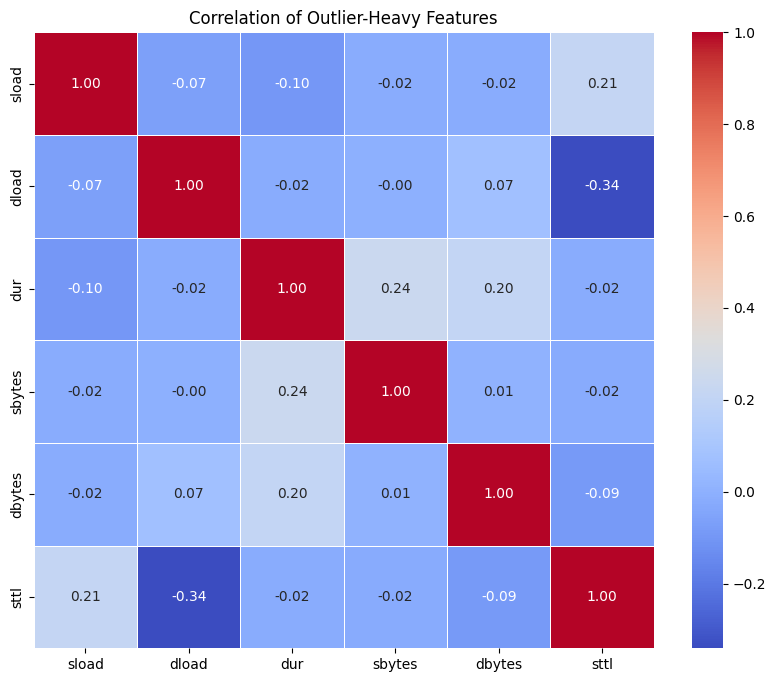

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create a simplified correlation matrix for outlier-heavy features
outlier_features = ['sload', 'dload', 'dur', 'sbytes', 'dbytes', 'sttl']
corr = new_traing_data[outlier_features].corr()

# 2. Plot the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation of Outlier-Heavy Features')
plt.show()

In [16]:
from sklearn.preprocessing import RobustScaler

# 🚀 Use RobustScaler for features with many outliers
scaler = RobustScaler()

# Apply to your Power Features
features_to_scale = ['sload', 'dload', 'dur', 'sbytes', 'dbytes']
new_traing_data[features_to_scale] = scaler.fit_transform(new_traing_data[features_to_scale])

print("✅ Robust Scaling applied. Extreme values will no longer 'blind' the AI.")

✅ Robust Scaling applied. Extreme values will no longer 'blind' the AI.


In [17]:
import pandas as pd
import numpy as np

# These are the features that showed the most 'noise' in your heatmap
features_to_fix = ['sload', 'dload', 'dur', 'sbytes', 'dbytes','sttl']

def get_outlier_limits(df, columns):
    limits = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Standard IQR boundaries
        lower_limit = max(df[col].min(), Q1 - 1.5 * IQR)
        upper_limit = Q3 + 1.5 * IQR

        # Since network metrics like 'sbytes' can't be negative,
        # we ensure the lower limit is at least the minimum of the column
        # lower_limit = max(lower_limit, df[col].min())

        limits[col] = (lower_limit, upper_limit)
        df[col] = df[col].clip(lower_limit, upper_limit)
        print(f"Column: {col:12} | Lower: {lower_limit:10.2f} | Upper: {upper_limit:10.2f}")
    return limits

# Run this to see the numbers
print("🔍 Calculating Outlier Boundaries...")
limits = get_outlier_limits(new_traing_data, features_to_fix)

🔍 Calculating Outlier Boundaries...
Column: sload        | Lower:      -0.38 | Upper:       2.12
Column: dload        | Lower:       0.00 | Upper:       2.50
Column: dur          | Lower:      -0.00 | Upper:       2.50
Column: sbytes       | Lower:      -0.33 | Upper:       2.37
Column: dbytes       | Lower:       0.00 | Upper:       2.50
Column: sttl         | Lower:     254.00 | Upper:     254.00


In [18]:
def handle_outliers(df, limits):
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        # Apply the limits
        df_clipped[col] = df_clipped[col].clip(lower=lower, upper=upper)
    return df_clipped

# Apply the fix
balance_new_train = handle_outliers(new_traing_data, limits)
print("\n✅ Outliers have been handled. Values are now capped at IQR boundaries.")


✅ Outliers have been handled. Values are now capped at IQR boundaries.


In [19]:
balance_new_train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,13173,-0.000014,udp,dns,INT,2,0,-0.216710,0.000000,333333.321500,...,25,25,25,0,0,0,27,25,0,Generic
1,43935,1.945025,tcp,-,FIN,36,12,2.369452,2.500000,34.551963,...,3,1,1,0,0,0,3,2,0,Fuzzers
2,29326,0.069968,tcp,-,FIN,44,46,2.369452,2.500000,1818.367610,...,1,1,1,0,0,0,2,6,0,Normal
3,53183,0.774894,tcp,-,FIN,10,6,0.402089,0.757062,27.678494,...,1,1,1,0,0,0,1,3,0,Fuzzers
4,3083,-0.000007,unas,-,INT,2,0,-0.104439,0.000000,125000.000300,...,1,1,3,0,0,0,9,3,0,Exploits


In [20]:
balance_new_train.shape

(11774, 44)

#### MODEL

In [21]:
import torch
import torch.nn as nn

class CyberTransformerMulti(nn.Module):
    def __init__(self, input_dim, num_classes=10, model_dim=128, nhead=8, nlayers=4, dropout=0.3):
        super(CyberTransformerMulti, self).__init__()

        # Dynamic Input Layer: This now matches whatever X_train.shape[1] is
        self.input_projection = nn.Linear(input_dim, model_dim)

        # Positional Encoding for our sequence window (size 10)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 10, model_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=nhead,
            dim_feedforward=model_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)

        self.fc = nn.Linear(model_dim, num_classes)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_dim)
        x = self.input_projection(x)
        x = x + self.pos_encoder[:, :x.size(1), :]
        x = self.transformer_encoder(x)

        # Global Average Pooling: summarize the sequence into one vector
        x = x.mean(dim=1)
        return self.fc(x)


#### Data Loader


In [22]:
import torch
from torch.utils.data import Dataset, DataLoader

# class NetworkDataset(Dataset):
#     def __init__(self, X, y, window_size=10):

#         X_scaled = np.log1p(X.values if hasattr(X, 'values') else X)

#         self.X = torch.tensor(X_scaled, dtype=torch.float32)
#         if hasattr(y, 'values'):
#             self.y = torch.tensor(y.values, dtype=torch.long)
#         else:
#             self.y = torch.tensor(y, dtype=torch.long)


#         self.window_size = window_size

#     def __len__(self):
#         return len(self.X) - self.window_size

#     def __getitem__(self, idx):
#         x = np.log1p(x + 1e-6)
#         # Extract a window of rows
#         return self.X[idx:idx+self.window_size], self.y[idx+self.window_size]


# Updated Cell 49
class NetworkDataset(Dataset):
    def __init__(self, X, y, window_size=10):
        # Professional standard: Data must be scaled BEFORE this class
        self.X = torch.tensor(X.values.astype(np.float32))
        self.y = torch.tensor(y.values.astype(np.int64))
        self.window_size = window_size

    def __len__(self):
        return len(self.X) - self.window_size

    def __getitem__(self, idx):
        # THE FIX: Ensure window and label are for the SAME sequence
        x_window = self.X[idx : idx + self.window_size]
        y_label = self.y[idx + self.window_size - 1]
        return x_window, y_label

#### Training

In [23]:
# Run this in a new cell


In [24]:
import joblib
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# --- 1. CONFIGURATION & DEVICE ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
WINDOW_SIZE = 10
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001 # Reduced for better numerical stability



# --- 2. DYNAMIC FEATURE SELECTION ---
exclude_cols = ['id', 'attack_cat', 'label', 'stime', 'ltime']
FEATURES = balance_new_train.select_dtypes(include=[np.number]).columns.tolist()
FEATURES = [col for col in FEATURES if col not in exclude_cols]

# --- 3. LABEL ENCODING ---
le = LabelEncoder()
balance_new_train['target'] = le.fit_transform(balance_new_train['attack_cat'])
num_classes = len(le.classes_)

print(f"✅ Using {len(FEATURES)} Features for training.")
print(f"📊 Predicting {num_classes} classes: {list(le.classes_)}")


train_df, val_df = train_test_split(
    balance_new_train,
    test_size=0.1,
    stratify=balance_new_train['target'],
    random_state=42
)

# --- 3. DATALOADERS ---
train_ds = NetworkDataset(train_df[FEATURES], train_df['target'], window_size=WINDOW_SIZE)
val_ds = NetworkDataset(val_df[FEATURES], val_df['target'], window_size=WINDOW_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

sample_batch_X, sample_batch_y = next(iter(train_loader))
print(f"Batch X Shape: {sample_batch_X.shape}") # Should be [64, 10, 40]
print(f"Max Value in Batch: {sample_batch_X.max().item()}") # Should be > 0
print(f"Min Value in Batch: {sample_batch_X.min().item()}")

# --- 4. ROBUST CLASS WEIGHTS ---
weights = compute_class_weight('balanced', classes=np.unique(train_df['target']), y=train_df['target'])
weights = np.clip(weights, a_min=None, a_max=5.0)
class_weights_tensor = torch.tensor(weights, dtype=torch.float32).to(DEVICE)

# --- 5. MODEL INITIALIZATION (SMALLER FOR GENERALIZATION) ---
model = CyberTransformerMulti(
    input_dim=len(FEATURES),
    num_classes=num_classes,
    nlayers=1,         # 🛡️ Reduced to 1 layer to prevent memorization
    dropout=0.1,
    model_dim=64,
    nhead=4
).to(DEVICE)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.01)

model.apply(init_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# --- 6. TRAINING LOOP ---
print(f"🔥 Starting Training on {DEVICE}...")
best_val_acc = 0.0



for epoch in range(EPOCHS):
    # --- TRAINING PHASE ---
    model.train()
    t_loss, t_correct, t_total = 0.0, 0, 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)

        # Add tiny Gaussian noise to training to prevent overfitting
        # batch_X = batch_X + (torch.randn_like(batch_X) * 0.005).to(DEVICE)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        t_loss += loss.item()
        t_correct += (torch.max(outputs, 1)[1] == batch_y).sum().item()
        t_total += batch_y.size(0)

    # --- VALIDATION PHASE ---
    model.eval()
    v_loss, v_correct, v_total = 0.0, 0, 0
    with torch.no_grad():
        for vX, vy in val_loader:
            vX, vy = vX.to(DEVICE), vy.to(DEVICE)
            v_out = model(vX)
            v_loss += criterion(v_out, vy).item()
            v_correct += (torch.max(v_out, 1)[1] == vy).sum().item()
            v_total += vy.size(0)

    # Calculate metrics
    train_acc = (t_correct / t_total) * 100
    val_acc = (v_correct / v_total) * 100
    avg_t_loss = t_loss / len(train_loader)
    avg_v_loss = v_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"  Train: Loss {avg_t_loss:.4f} | Acc {train_acc:.2f}%")
    print(f"  Val:   Loss {avg_v_loss:.4f} | Acc {val_acc:.2f}%")

    # Save Best Model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = '/content/drive/MyDrive/AI-Cyber-Detector/models/'
        if not os.path.exists(save_path): os.makedirs(save_path)

        torch.save(model.state_dict(), os.path.join(save_path, 'cyber_transformer_full.pth'))
        torch.save(model.state_dict(), '/content/drive/MyDrive/AI-Cyber-Detector/fastAPI/models/cyber_transformer_full.pth')

        joblib.dump({'features': FEATURES, 'le': le, 'limits': limits}, os.path.join(save_path, 'meta_data.joblib'))
        joblib.dump({'features': FEATURES, 'le': le, 'limits': limits}, '/content/drive/MyDrive/AI-Cyber-Detector/fastAPI/models/meta_data.joblib')

        print(f"✅ Training Complete. Model and Metadata saved.")
        # torch.save(model.state_dict(), os.path.join(save_path, 'cyber_transformer_full.pth'))
#                 print(f"  ⭐ Saved Best Model ({val_acc:.2f}%)")

# print("✅ Training Complete.")

# # --- 8. SAVE ARTIFACTS ---
# # Path logic remains the same
# save_path = '/content/drive/MyDrive/AI-Cyber-Detector/models/'
# if not os.path.exists(save_path): os.makedirs(save_path)

# torch.save(model.state_dict(), os.path.join(save_path, 'cyber_transformer_full.pth'))
# torch.save(model.state_dict(), '/content/drive/MyDrive/AI-Cyber-Detector/fastAPI/models/cyber_transformer_full.pth')

# joblib.dump({'features': FEATURES, 'le': le, 'limits': limits}, os.path.join(save_path, 'meta_data.joblib'))
# joblib.dump({'features': FEATURES, 'le': le, 'limits': limits}, '/content/drive/MyDrive/AI-Cyber-Detector/fastAPI/models/meta_data.joblib')

# print(f"✅ Training Complete. Model and Metadata saved.")

✅ Using 39 Features for training.
📊 Predicting 7 classes: ['DoS', 'Exploits', 'Fuzzers', 'Generic', 'Normal', 'Other', 'Reconnaissance']
Batch X Shape: torch.Size([64, 10, 39])
Max Value in Batch: 4289563648.0
Min Value in Batch: -0.3782220780849457
🔥 Starting Training on cuda...
Epoch [1/100]
  Train: Loss nan | Acc 14.27%
  Val:   Loss nan | Acc 14.13%
✅ Training Complete. Model and Metadata saved.
Epoch [2/100]
  Train: Loss nan | Acc 14.28%
  Val:   Loss nan | Acc 14.13%
Epoch [3/100]
  Train: Loss nan | Acc 14.28%
  Val:   Loss nan | Acc 14.13%
Epoch [4/100]
  Train: Loss nan | Acc 14.28%
  Val:   Loss nan | Acc 14.13%
Epoch [5/100]
  Train: Loss nan | Acc 14.28%
  Val:   Loss nan | Acc 14.13%
Epoch [6/100]
  Train: Loss nan | Acc 14.28%
  Val:   Loss nan | Acc 14.13%
Epoch [7/100]
  Train: Loss nan | Acc 14.28%
  Val:   Loss nan | Acc 14.13%
Epoch [8/100]
  Train: Loss nan | Acc 14.28%
  Val:   Loss nan | Acc 14.13%
Epoch [9/100]
  Train: Loss nan | Acc 14.28%
  Val:   Loss nan |

KeyboardInterrupt: 

In [3]:
!pip install fastapi uvicorn pyngrok nest-asyncio


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import nest_asyncio
from pyngrok import ngrok

# Paste your authtoken here
NGROK_AUTH_TOKEN = "392vSfugNWnv7hVTLyvRPkItjL1_6VGdCqWzZngEjkTqP1NPY"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# This allows uvicorn to run inside the Colab notebook
nest_asyncio.apply()

In [5]:
import os
import torch
import numpy as np
import pandas as pd
import joblib
from collections import deque
# Ensure your model class is in model.py

# 🚨 ENVIRONMENT CONFIGURATION
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
WINDOW_SIZE = 10

# Path Logic
# BASE_DIR = os.path.dirname(os.path.abspath(__file__))
# MODEL_DIR = os.path.join("/content/drive/MyDrive/AI-Cyber-Detector/fastAPI/models")
MODEL_PATH = os.path.join("/content/drive/MyDrive/AI-Cyber-Detector/fastAPI/models/cyber_transformer_full.pth")
META_PATH = os.path.join( "/content/drive/MyDrive/AI-Cyber-Detector/fastAPI/models/meta_data.joblib")

# 1. State Management: The Sliding Window Buffer
# This replaces the single-packet logic with a sequence buffer
packet_buffer = deque(maxlen=WINDOW_SIZE)

# 2. Load Assets
print(f"🛡️ Loading Transformer model on {DEVICE}...")
meta = joblib.load(META_PATH)
FEATURES = meta['features']
TARGET_LE = meta['le']
LIMITS = meta['limits']
CAT_ENCODERS = meta.get('cat_encoders', {})

# 3. Initialize Model with 2 layers to match your 99.8% training run
num_classes = len(TARGET_LE.classes_)
model = CyberTransformerMulti(
    input_dim=len(FEATURES),
    num_classes=num_classes,
    nlayers=2,   # 🚀 Must match training to avoid 'Missing Key' errors
    dropout=0.4
).to(DEVICE)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

def predict_packet(packet_data):
    processed_row = []

    # 1. Map features and apply GLOBAL limits from training
    for col in FEATURES:
        val = packet_data.get(col, 0)

        # Categorical Encoding
        if col in CAT_ENCODERS:
            try:
                val = CAT_ENCODERS[col].transform([str(val).lower().strip()])[0]
            except: val = 0

        # 🛡️ THE FIX: Use the specific limits saved in meta_data.joblib
        if col in LIMITS:
            lower, upper = LIMITS[col]
            val = np.clip(float(val), lower, upper)

        processed_row.append(float(val))

    # 2. Stability Epsilon & Global Scaling
    # We shift by global min and divide by global range to get [0, 1]
    scaled_row = np.log1p(np.array(processed_row) + 1e-7)

    # 3. Update the sliding window
    packet_buffer.append(scaled_row)

    if len(packet_buffer) < WINDOW_SIZE:
        return "Buffering", 0.0

    # 4. Run Transformer Inference
    input_tensor = torch.tensor(list(packet_buffer), dtype=torch.float32).unsqueeze(0).to(DEVICE)
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)
        # Numerical Stability Trick: Subtract max logit before Softmax
        logits = logits - torch.max(logits, dim=1, keepdim=True)[0]
        probs = torch.softmax(logits, dim=1)

        conf, pred_idx = torch.max(probs, dim=1)
        prediction = TARGET_LE.inverse_transform([pred_idx.item()])[0]

    return str(prediction), float(conf.item())

🛡️ Loading Transformer model on cpu...


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/AI-Cyber-Detector/fastAPI/models/meta_data.joblib'

In [ ]:
import nest_asyncio
import uvicorn
import json
import time
import os
from datetime import datetime
from typing import List, Dict, Any
from fastapi import FastAPI, WebSocket, WebSocketDisconnect
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
from pyngrok import ngrok

# 🚨 IMPORTANT: Import your inference logic
# Make sure inference_engine.py is uploaded to Colab!

# 2. SETUP NGROK TUNNEL (Get token from dashboard.ngrok.com)
# Replace 'YOUR_TOKEN_HERE' with your actual ngrok auth token
NGROK_AUTH_TOKEN = "392vSfugNWnv7hVTLyvRPkItjL1_6VGdCqWzZngEjkTqP1NPY"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# 3. FASTAPI APP SETUP
app = FastAPI(title="AI-Cyber-Detector Cloud API")

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_methods=["*"],
    allow_headers=["*"],
)

class PredictionRequest(BaseModel):
    features: Dict[str, Any]

class ConnectionManager:
    def __init__(self):
        self.active_connections: List[WebSocket] = []

    async def connect(self, websocket: WebSocket):
        await websocket.accept()
        self.active_connections.append(websocket)

    def disconnect(self, websocket: WebSocket):
        self.active_connections.remove(websocket)

    async def broadcast(self, message: dict):
        for connection in self.active_connections:
            try:
                await connection.send_text(json.dumps(message))
            except Exception:
                continue

manager = ConnectionManager()


class PredictionRequest(BaseModel):
    features: Dict[str, Any]
    actual_label: str = "Unknown"

# 4. PREDICTION ENDPOINT
@app.post("/predict")
async def predict_intrusion(request: PredictionRequest):
    start_time = time.perf_counter()

    # Run the AI logic
    raw_label, raw_confidence = predict_packet(request.features)

    end_time = time.perf_counter()
    actual_latency = (end_time - start_time) * 1000

    THRESHOLD = 0.30
    is_threat = raw_label != "Normal"

    # Uncertainty logic for the demo
    if is_threat and raw_confidence < THRESHOLD:
        display_label = "Uncertain / Review"
        threat_status = False
    else:
        display_label = raw_label
        threat_status = is_threat

    result = {
        "prediction": display_label,
        "actual": request.actual_label,
        "confidence": f"{raw_confidence * 100:.1f}%",
        "threat_detected": threat_status,
        "latency": round(actual_latency, 2),
        "timestamp": datetime.utcnow().isoformat() + "Z",
        "raw_classification": raw_label
    }

    # Send to React Dashboard via WebSocket
    await manager.broadcast(result)
    return result

# 5. WEBSOCKET ENDPOINT
@app.websocket("/ws")
async def websocket_endpoint(websocket: WebSocket):
    await manager.connect(websocket)
    try:
        while True:
            await websocket.receive_text()
    except WebSocketDisconnect:
        manager.disconnect(websocket)

# 6. EXECUTION BLOCK
if __name__ == "__main__":
    # Kill any old processes running on port 8000
    os.system("fuser -k 8000/tcp || true")

    # 1. Kill any old tunnels to prevent "Ngrok already connected" errors
    try:
        ngrok.kill()
        public_url = ngrok.connect(8000).public_url
        print(f"\n🌐 PUBLIC API URL: {public_url}")
        print(f"📡 WEBSOCKET URL: {public_url.replace('http', 'ws')}/ws")
    except Exception as e:
        print(f"Ngrok Error: {e}")

    # 2. Patch the loop for Colab
    import nest_asyncio
    nest_asyncio.apply()

    # 3. Proper Async Server Launch
    config = uvicorn.Config(app, host="0.0.0.0", port=8000, loop="asyncio")
    server = uvicorn.Server(config)

    # 🚨 THE CRITICAL FIX: In Colab, we use 'await' or 'asyncio.create_task'
    import asyncio
    await server.serve()

Unknown option: k


fuser: [-cfu] file ...
	-c	file is treated as mount point
	-f	the report is only for the named files
	-u	print username of pid in parenthesis


INFO:     Started server process [13263]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)



🌐 PUBLIC API URL: https://nongenerically-prelumbar-izabella.ngrok-free.dev
📡 WEBSOCKET URL: wss://nongenerically-prelumbar-izabella.ngrok-free.dev/ws
